# Visualization of coordinates on a sample image

## Imports and declarations

In [1]:
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights

from wings.config import COUNTRIES, RAW_DATA_DIR
from wings.config import MODELS_DIR
from wings.dataset import Dataset
from wings.modeling.litnet import LitNet
from wings.modeling.models import ResnetPreTrained
from wings.visualizing.image_preprocess import denormalize
from wings.visualizing.image_preprocess import preprocess
from wings.visualizing.visualize import visualize_coords
from wings.visualizing.visualize import visualize_from_file

2025-04-06 20:23:30.878 | INFO     | wings.config:<module>:7 - PROJ_ROOT path is: /home/mkrajew/bees
2025-04-06 20:23:31.582 | INFO     | wings.config:<module>:28 - torch.cuda.get_device_name()='NVIDIA RTX A3000 12GB Laptop GPU'


In [2]:
resnet_dataset = Dataset(COUNTRIES, RAW_DATA_DIR, preprocess)

100%|██████████| 21722/21722 [00:00<00:00, 105837.68it/s]


## Visualization raw image and coordinates from file

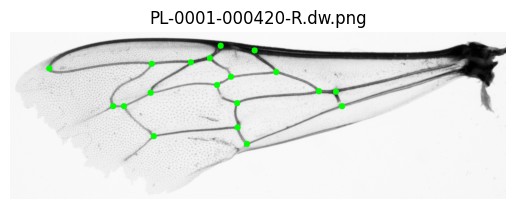

In [3]:
visualize_from_file(filename="PL-0001-000420-R.dw.png")

## Visualize output from model

### Declare model

In [4]:
checkpoint_path = MODELS_DIR / 'resnet_pretrained_v02.ckpt'
weights = ResNet50_Weights.DEFAULT
resnet_model = ResnetPreTrained(resnet50, weights)

num_epochs = 15
model = LitNet.load_from_checkpoint(checkpoint_path, model=resnet_model, num_epochs=num_epochs)
model.eval()

max_n = len(resnet_dataset)
print(max_n)

21722


### Visualize

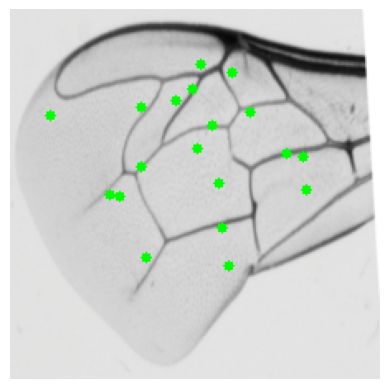

In [5]:
n = np.random.randint(0, max_n)
image, label = resnet_dataset[n]
labels = model(image.cuda().unsqueeze(0))
image = denormalize(image)
visualize_coords(image, labels.squeeze(0), spot_size=3)
